In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import sketch

# 1. Data Inspection

In [ ]:
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')
df.head()

In [ ]:
df.info()

In [ ]:
df.describe()

### Checking Null Values

In [ ]:
df.isna().sum()

### Duplicate records

In [ ]:
df.duplicated().sum()

### Duplicated Fraud transactions

In [ ]:
df.loc[df.duplicated() & df['Class']==1]

**We have some Fraud transactions duplicated even more than twice this maybe data collecting error or maybe these all were actually Fraud transaction that repeated with exact same figures**

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
# mask = df > 0
# mask_all = mask.all(axis=1)
# df_positive = df[mask_all]

# df_positive

### Correlation of features with the target

In [ ]:
df.corr()['Class'].sort_values(ascending=False).plot(kind='bar')
plt.show()

### Checking Multicollinearinty in the independent columns

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# creating dummies for gender
# the independent variables set
X = df.iloc[:, :-1]

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

In [ ]:
vif_data.set_index('feature').sort_values(by='VIF', ascending=False).plot(kind='bar')
plt.xlabel('Feature')
plt.ylabel('VIF value')
plt.show()

**For a good model VIF should be less than 5 so we will have to transform our data**

### Transforming data and checking VIF again

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer
# I cannot use log tranformation as there are alot negative values almost in every row of our data so yeo-johnson method wil be nice
column_trans = ColumnTransformer(
    [('yeo-johnson', PowerTransformer(method='yeo-johnson'), list(df.iloc[:,:-1].columns))],
    remainder='passthrough'
)
transformed = column_trans.fit_transform(df)
df_tr = pd.DataFrame(transformed, columns=df.columns)
df_tr.head()

In [ ]:
X = df_tr.iloc[:, :-1]

# VIF dataframe
vif_data_tr = pd.DataFrame()
vif_data_tr["feature"] = X.columns

# calculating VIF for each feature
vif_data_tr["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

In [ ]:
vif_data_tr.set_index('feature').sort_values(by='VIF', ascending=False).plot(kind='bar')
plt.xlabel('Feature')
plt.ylabel('VIF value')
plt.show()

**The power transformer solved the issue**

# 2. Data Visualization

In [ ]:
def make_histograms(df=df,rows=10,cols=3,figsize=(20,20)):
    num_columns = list(df.select_dtypes(include=np.number).columns)
    fig ,ax = plt.subplots(rows,cols,figsize=figsize)
    for j in range(rows):
        for i in range(cols):
            try:
                sns.histplot(data=df,x=num_columns[0],kde=True,bins=20,ax=ax[j][i])
                num_columns.pop(0)
            except:
                fig.delaxes(ax=ax[j][i])
    fig.suptitle('Histograms of numerical columns', fontsize=16)
    plt.show()
def make_boxplots(df=df,rows=3,cols=2,figsize=(15,15)):
    num_columns = list(df.select_dtypes(include=np.number).columns)
    fig ,ax = plt.subplots(rows,cols,figsize=figsize)
    for j in range(rows):
        for i in range(cols):
            try:
                sns.boxplot(data=df,x=num_columns[0],ax=ax[j][i])
                num_columns.pop(0)
            except:
                fig.delaxes(ax=ax[j][i])
    fig.suptitle('Boxplots of numerical columns', fontsize=16)
    plt.show()


### Numerical distribution of features

In [ ]:
make_histograms(df_tr,10,3,(20,35))

### Target Class distribution

In [ ]:
ax = sns.countplot(data=df_tr,x='Class')
ax.set_xticklabels(['Not Fraud', 'Fraud'])
print(df_tr['Class'].value_counts())
plt.show()

**We have only 473 cases of Fraud transaction**

# 3. Model Building

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,ConfusionMatrixDisplay,precision_score,recall_score,f1_score,roc_auc_score,roc_curve,precision_recall_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier,VotingClassifier,AdaBoostClassifier

In [ ]:
X = df_tr.drop('Class', axis=1)
y = df_tr['Class']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101,stratify=y)

### We have stratified split with equal percentage fraud and non fraud classes in test and train set 

In [ ]:
print(f'percentage of Fraud in train set {len(y_train[y_train.values==1])/len(X_train)*100:.2f} %')
print(f'percentage of non-Fraud in train set {len(y_train[y_train.values==0])/len(X_train)*100:.2f} %')
print(f'percentage of Fraud in test set {len(y_test[y_test.values==1])/len(X_test)*100:.2f} %')
print(f'percentage of non-Fraud in test set {len(y_test[y_test.values==0])/len(X_test)*100:.2f} %')

## What do we need?

***As we need to find every transaction that is a Fraud so we want to reduce the number of false negatives in our result. It can be done by increasing recall score.***

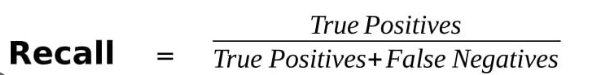

**But due to precision recall tradeoff our model will start to classify transactions that are not fraud as fraud. But we need to focus on fraud transactions so we will tend to maximize recall**

### our data is extremely imbalanced we will try to change the class weights to get maximum recall score

In [ ]:
weights = [50,60,70,80,100,120]
for weight in weights:
    lg =  LogisticRegression(max_iter=500,C=0.1, class_weight={0: 1, 1: weight})
    lg.fit(X_train, y_train)
    lg_pred = lg.predict(X_test)
    print(f'for class weight of 0:1 and 1:{weight}')
    print(f'precision {precision_score(y_test, lg_pred):.3f}')
    print(f'recall {recall_score(y_test, lg_pred):.3f}')
    print(f'f1 {f1_score(y_test, lg_pred):.3f}')

### So, the best value for wieghts of 1 is 60

In [ ]:
lg =  LogisticRegression(max_iter=500,C=0.1, class_weight={0: 1, 1: 60},random_state=101)
lg.fit(X_train, y_train)

In [ ]:
lg_pred = lg.predict(X_test)
print(f'precision score :{precision_score(y_test, lg_pred):.3f}')
print(f'recall score :{recall_score(y_test, lg_pred):.3f}')
print(f'f1 score :{f1_score(y_test, lg_pred):.3f}')

In [ ]:
lg_pred_train = lg.predict(X_train)
print(f'precision score :{precision_score(y_train, lg_pred_train):.3f}')
print(f'recall score :{recall_score(y_train, lg_pred_train):.3f}')
print(f'f1 score :{f1_score(y_train, lg_pred_train):.3f}')

**So there is not much overfitting**

### Using enesembles

In [ ]:
bag_clf = BaggingClassifier(
    estimator=lg,
    max_samples=0.9,
    n_estimators=10,
    bootstrap=True,
    random_state=101,
    bootstrap_features=True
)
bag_clf.fit(X_train, y_train)
bag_pred = bag_clf.predict(X_test)

print(f'precision score :{precision_score(y_test, bag_pred):.3f}')
print(f'recall score :{recall_score(y_test, bag_pred):.3f}')
print(f'f1 score :{f1_score(y_test, bag_pred):.3f}')

In [ ]:
lr1 = LogisticRegression(max_iter=500,C=0.1, class_weight={0: 1, 1: 60},random_state=101)
lr2 = LogisticRegression(max_iter=500,C=0.1, class_weight={0: 1, 1: 40},random_state=101)
lr3 =LogisticRegression(max_iter=500,C=0.1, class_weight={0: 1, 1: 100},random_state=101)
lr4 = LogisticRegression(max_iter=500,C=0.1, class_weight={0: 1, 1: 80},random_state=101)
voting_clf = VotingClassifier(
    estimators=[('lr1', lr1), ('lr2', lr2),('lr3', lr3), ('lr4', lr4)],
    voting='soft', 
#     weights=[1,0.9,0.8,0.7]
)
voting_clf.fit(X_train, y_train)
vot_pred = voting_clf.predict(X_test)

print(f'precision score :{precision_score(y_test, vot_pred):.3f}')
print(f'recall score :{recall_score(y_test, vot_pred):.3f}')
print(f'f1 score :{f1_score(y_test, vot_pred):.3f}')

### Bagging classifier has the best roc auc score

In [ ]:
lg_pred_proba = lg.predict_proba(X_test)[:,1]
# calculate AUC of model
auc_lg = roc_auc_score(y_test, lg_pred_proba)
fpr_lg, tpr_lg, _ = roc_curve(y_test,  lg_pred_proba)
bag_pred_proba = bag_clf.predict_proba(X_test)[:,1]
# calculate AUC of model
auc_bag = roc_auc_score(y_test, bag_pred_proba)
fpr_bag, tpr_bag, _ = roc_curve(y_test,  bag_pred_proba)
vot_pred_proba = voting_clf.predict_proba(X_test)[:,1]
# calculate AUC of model
auc_vot = roc_auc_score(y_test, vot_pred_proba)
fpr_vot, tpr_vot, _ = roc_curve(y_test,  vot_pred_proba)
plt.plot(fpr_vot,tpr_vot,label="voting classifier, auc="+str(auc_vot))
plt.plot(fpr_lg,tpr_lg,label="logistic regression, auc="+str(auc_lg))
plt.plot(fpr_bag,tpr_bag,label="bagging classifier, auc="+str(auc_bag))
plt.legend(loc=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate or recall')
plt.show()

### While Logistic regression produces a good classification matrix based on our problem

In [ ]:
matrix = confusion_matrix(y_test, lg_pred)
matrix_display = ConfusionMatrixDisplay(matrix,display_labels=['Not Fraud','Fraud'])
matrix_display.plot()
plt.title('Confusion matrix for Logistic regression')
plt.show()

In [ ]:
matrix = confusion_matrix(y_test, vot_pred)
matrix_display = ConfusionMatrixDisplay(matrix,display_labels=['Not Fraud','Fraud'])
matrix_display.plot()
plt.title('Confusion matrix for Voting classifier')
plt.show()

In [ ]:
matrix = confusion_matrix(y_test, bag_pred)
matrix_display = ConfusionMatrixDisplay(matrix,display_labels=['Not Fraud','Fraud'])
matrix_display.plot()
plt.title('Confusion matrix for Bagging classifier')
plt.show()

### We can further increse recall by lowering the threshold for logistic regression

In [ ]:
lg_pred_new_threshold = (lg.predict_proba(X_test)[:, 1] >= 0.3).astype(int)

# Evaluation metrics for new threshold
print("Evaluation metrics with threshold 0.3:")
print("Accuracy:", accuracy_score(y_test, lg_pred_new_threshold))
print("Precision:", precision_score(y_test, lg_pred_new_threshold))
print("Recall:", recall_score(y_test, lg_pred_new_threshold))
print("F1 Score:", f1_score(y_test, lg_pred_new_threshold))

### KIndly upvote if you like 